In [1]:
# Import namespaces
import sys
import os
import math
import itertools
import json
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandapower as pp
from scipy.optimize import linprog, minimize
from scipy.optimize import NonlinearConstraint
import scipy.integrate as integrate

from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multinomial
from scipy.linalg import pinvh
from pandapower import networks

from tqdm.notebook import tqdm, trange
import time 

from numba import njit, jit

# Setting up polytope
[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Regular_polygon_8_annotated.svg/1200px-Regular_polygon_8_annotated.svg.png" width="400">]()


In [2]:
##### Setup polytope and r.v. ########

## Std considered to be 1: 

cov_std = 1

##### Setup regular polytope ########
### number of planes and distance
J = 8
tau = 3


### Matrix 
x_An = []
### Matrix rows
for i in range(J):
    x_An.append([math.sin(2 * math.pi * i / (J - 1)), math.cos(2 * math.pi * i / (J - 1))])
x_An = np.array(x_An)
### Distances
x_bn = np.ones(J) * tau
n = x_An.shape[1]

# Distirbution of maximum of normals - LEMMA
Let us first spend some words of the random variable
$$
Y = \max_i (X_1, \dots, X_m), ~X_i \sim \mathcal{N}(\mu_i, \sigma_i).
$$
In our case, we meet such random variable in the form of
$$
Y = \max_i (a_i^\top x - d_i - \xi_i), ~ \xi_i \sim \mathcal{N}(0, 1).
$$
In the case considered, $X_i = a_i^\top x - d_i - \xi_i \sim \mathcal{N}(\mu_i, 1)$, where $\mu_i = d_i - a_i^\top x$.
Let us obtain the distribution of the random variable $Y$ in a general case.

First of all, let us note that
$$
F_Y(y) = \mathbb{P}(\max_i (X_1, \dots, X_m) \leq y).
$$
The event $\max_i (X_1, \dots, X_n) \leq y$ means that each of the $X_i, ~ i=1,\dots, m$ are less of equal to $y$. Thus, the cumulative distribution function of $Y$ is given as
$$
F_Y(y) = \mathbb{P}(\max_i (X_1, \dots, X_m) \leq y) = \prod_{i=1}^m \mathbb{P}(X_i \leq y) = \prod_{i=1}^m \Phi \left(\frac{y - \mu_i}{\sigma_i} \right).
$$
One can obtain the probability density function of $Y$ by taking partial derivative: $f_Y(y) = \frac{\partial}{\partial y} F_Y(y)$. Let us make some preprocessing before the computation:
$$
F_Y(y) = \prod_{i=1}^m \Phi \left(\frac{y - \mu_i}{\sigma_i} \right) = \exp \left[ \sum_{i=1}^m \log \left( \Phi \left(\frac{y - \mu_i}{\sigma_i} \right) \right) \right].
$$
Taking the partial derivative $\frac{\partial}{\partial y}$, one can easily obtain that
$$
f_Y(y) = \frac{\partial}{\partial y} F_Y(y) = \sum_{i=1}^m \frac{\phi\left( (y - \mu_i) / \sigma_i\right)}{\sigma_i \Phi\left( (y - \mu_i) / \sigma_i\right)} \cdot \exp \left[ \sum_{i=1}^m \log \left( \Phi \left(\frac{y - \mu_i}{\sigma_i} \right) \right) \right] = \sum_{i=1}^m \frac{\phi\left( (y - \mu_i) / \sigma_i\right)}{\sigma_i \Phi\left( (y - \mu_i) / \sigma_i\right)} \cdot \prod_{i=1}^m \Phi \left(\frac{y - \mu_i}{\sigma_i} \right).
$$

Let us use the obtained result for the $Y = \max_i (X_1, \dots, X_m), ~X_i \sim \mathcal{N}(\mu_i, \sigma_i)$. In this case $Y$ will have the following probability density function:
\begin{equation}
f_Y(y) = \sum_{i=1}^m \frac{\phi\left( y - \mu_i \right)}{\Phi\left( y - \mu_i\right)} \cdot \prod_{i=1}^m \Phi \left(y - \mu_i \right), ~ \mu_i = a_i^\top x - d_i
\label{eq:max_pdf}
\end{equation}

- !Remark!

For computational stability purpose it is recommended to use the following expression for the density $f_Y(y)$:
$$
f_Y(y) =  \sum_{i=1}^m \left[ \frac{\phi\left( (y - \mu_i) / \sigma_i\right)}{\sigma_i} \cdot \prod_{j=1, j\neq i}^m \Phi \left(\frac{y - \mu_i}{\sigma_i} \right)\right].
$$


# Joint CC - Ground Truth
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{P} \{ \max_i (a_i^\top x - d_i - \xi_i) \leq 0 \} \geq 1 - \eta,
    \end{aligned}
$$
The problem can be reformulated as follows, using the knowledge about distributions of maximum:

$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & F_Y(0) =  \prod_{i=1}^m \Phi \left(- (a_i^\top x - d_i) \right)
 \geq 1 - \eta,
    \end{aligned}
$$
Or, equivelently,
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \sum_{i=1}^m \log \Phi \left(- (a_i^\top x - d_i) \right) \geq \log(1 - \eta),
    \end{aligned}
$$

In [3]:
def joint_cc_gt(x):
    vec = np.dot(x_An, x) - x_bn
    #mean = np.max(vec)
    #return -mean
    return np.sum(np.array([np.log(norm.cdf(-v)) for v in vec]))
def objective(c, x):
    return np.dot(c, x)
def objective_barrier(c, x, constr_foo, r):
    return np.dot(c, x[:n]) + r * np.max((0.,constr_foo(x))) ** 2
def check_cc(x):
    return np.exp(joint_cc_gt(x))
def check_cc_scenario(x, nsmp=10000):
    cnter = 0
    vec = np.dot(x_An, x) - x_bn
    for i in range(nsmp):
        val = vec - np.random.normal(0, 1, len(vec))
        if max(val) <= 0:
            cnter += 1
    return cnter / nsmp

In [4]:
eta = 0.1
def ground_truth(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    nl_constraints = [NonlinearConstraint(joint_cc_gt, lb = [np.log(1. - eta)], ub=[np.inf], keep_feasible=True)]
    res = minimize(fun=lambda x: objective(cost_coeffs, x), x0=[0.0, 0.0], constraints=nl_constraints, method='trust-constr')
    #linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn + norm.ppf(eta), bounds=[(l[i], u[i]) for i in range(len(l))])
    return res
res = ground_truth(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x))
print("empirical constraint value:", check_cc_scenario(res.x))

obj: -2.0910276552156586
x: [-1.04328128 -1.04774638]
constraint value: 0.9000007837947754
empirical constraint value: 0.8981


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


# Outer Polyhedral Approximation -- Solving Linear Program

\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \mathbb{P} (a_i^\top x - d_i \leq \xi_i) \geq 1 - \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}

The L.H.S of each constraint can be rewritten as 
$$
\mathbb{P} (a_i^\top x - d_i \leq \xi_i) = \mathbb{P} (-\xi_i \leq - a_i^\top x + d_i) = \texttt{cdf}_{\mathcal{N}(0, 1)} (- a_i^\top x + d_i).
$$
Thus, the problem can be reformulated as follows:
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \texttt{cdf}_{\mathcal{N}(0, 1)} (- a_i^\top x + d_i) \geq 1 - \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \texttt{cdf}_{\mathcal{N}(0, 1)} (a_i^\top x - d_i) \leq \eta, ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}
Finally,
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & a_i^\top x - d_i \leq \Phi^{-1}(\eta), ~ \xi_i \sim \mathcal{N}(0, 1), ~i=1,\dots, m
    \end{aligned}
\end{equation}

In [5]:
### Solving linear program
### c^T gens -> min
### s.t. A_n gens <= b_n + \Phi^{-1}(eta)
### l <= gens <= u *
### * in such a way that only net.gen['bus'] are non-zero
def outer_polyhedral(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    l = -np.ones(x_An.shape[1]) * np.inf
    u = np.ones(x_An.shape[1]) * np.inf
    res = linprog(c = cost_coeffs, A_ub = x_An, b_ub = x_bn - norm.ppf(1-eta), bounds=[(l[i], u[i]) for i in range(len(l))])
    return res
res = outer_polyhedral(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x))
print("empirical constraint value:", check_cc_scenario(res.x))

obj: -2.6804168789722618
x: [-1.49121366 -1.18920321]
constraint value: 0.8018803551530523
empirical constraint value: 0.8049


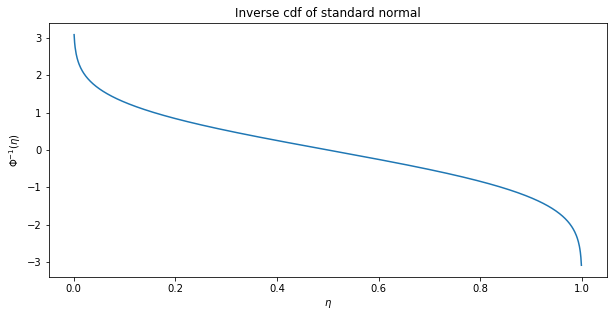

In [6]:
# - \Phi^{-1}(\eta)
plt.figure(figsize=(10,7*2/3))
xs = np.linspace(0, 1, 1000)
ys = [-norm.ppf(x) for x in xs]
plt.plot(xs, ys)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\Phi^{-1}(\eta)$')
plt.title('Inverse cdf of standard normal')
plt.show()

# Inner Polyhedral Approximation -- Solving Linear Program
Based on Bool's theorem, we obtain more strict (inner) approximation of the original problem:
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \sum_{i=1}^m\mathbb{P} (a_i^\top x - d_i \leq \xi_i) \geq 1 - \eta, ~ \xi_i \sim \mathcal{N}(0, 1)
    \end{aligned}
\end{equation}
Equivalently,
\begin{equation}
    \begin{aligned}
        \texttt{min }  &c^\top x \\
        \texttt{s.t. } & \sum_{i=1}^m\Phi(a_i^\top x - d_i) \leq  \eta
    \end{aligned}
\end{equation}

In [7]:
def inner_polyhedral_constraint(x):
    vec = np.dot(x_An, x) - x_bn
    cdf_vec = [norm.cdf(v) for v in vec]
    sum_ = np.sum(cdf_vec)
    return sum_ - eta

def inner_polyhedral(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    res = minimize(fun=lambda x: objective_barrier(cost_coeffs, x, inner_polyhedral_constraint, 2000), x0=[-0.1, -0.1], method='Nelder-Mead')
    #constraint = [NonlinearConstraint(lambda x: np.sum([norm.cdf(-np.dot(x_An[i,:], x) + x_bn[i])]),lb = 1 - eta, ub = np.inf)]
    #res = minimize(fun=lambda x: objective(cost_coeffs, x), x0=[-0.1, -0.1], constraints=constraint, method='trust-constr')
    return res
res = inner_polyhedral(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x))
print("empirical constraint value:", check_cc_scenario(res.x))


obj: -2.075478533310101
x: [-1.0378494  -1.04519809]
constraint value: 0.9009739846601404
empirical constraint value: 0.9039


# Joint CC - Markov
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)_+ \leq \eta t,
    \end{aligned}
$$
The expectation can be computed as follows:
$$
\mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)_+  = \int (y + t)_+ f_Y(y) dy.
$$
Note that $f_Y(y) = f_Y(y, a_i, x, d_i)$.

In [8]:
@njit
def pdf_max(y, mu):
    out = 0.0
    pdf_ = lambda x: 1. / np.sqrt(2 * np.pi) * np.exp(- 0.5 * x ** 2)
    cdf_ = lambda x: 0.5 * (1. + math.erf(x / math.sqrt(2)))
    for i in range(len(mu)):
        #out += norm.pdf(y - mu[i]) * np.exp(np.sum([np.log(norm.cdf(y - mu[j])) for j in range(len(mu)) if j != i]))
        out += pdf_(y - mu[i]) * np.prod(np.array([(cdf_(y - mu[j])) for j in range(len(mu)) if j != i]))
    return out
def compute_E(foo, density):
    res = integrate.quad(lambda y: foo(y) * density(y), -np.inf, np.inf)
    return res[0]


In [9]:
x = np.ones(n)
t = 0
mu = (np.dot(x_An, x) - x_bn)
density = lambda y: pdf_max(y, mu)
foo = lambda y:  1
t1 = time.time()
print(compute_E(foo, density))
t2 = time.time()
print("execution time:", t2 - t1)

1.0
execution time: 0.4160938262939453


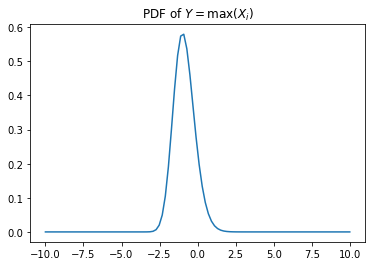

In [10]:
x = np.zeros(n) + 1
mu = (np.dot(x_An, x) - x_bn)
xs = np.linspace(-10, 10, 100)
ys = [pdf_max(x, mu) for x in xs]
plt.title(r'PDF of $Y = \max (X_i)$')
plt.plot(xs, ys)

In [11]:
def constr_markov(var):
    x = var[:-1]
    t = var[-1]
    mu = (np.dot(x_An, x) - x_bn)
    density = lambda y: pdf_max(y, mu)
    foo = lambda y: np.max((0., y + t))
    integral = compute_E(foo=foo, density=density)
    return integral - eta * t

In [12]:
def markov(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    res = minimize(fun=lambda x: objective_barrier(cost_coeffs, x, constr_markov, 2000), x0=[0.1, 0.1, 0.1], method='Nelder-Mead')
    return res
res = markov(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x[:-1]))
print("empirical constraint value:", check_cc_scenario(res.x[:-1]))


obj: -1.4166183417169185
x: [-0.72658061 -0.73135665  0.35524105]
constraint value: 0.9562760742453063
empirical constraint value: 0.9567


# Joint CC - Chebyshev
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)^2_+ \leq \eta t^2,
    \end{aligned}
$$
The expectation can be computed as follows:
$$
\mathbb{E} \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) + t \right)^2_+  = \int (y + t)^2_+ f_Y(y) dy.
$$
Note that $f_Y(y) = f_Y(y, a_i, x, d_i)$.

In [13]:
def constr_chebyshev(var):
    x = var[:-1]
    t = var[-1]
    mu = (np.dot(x_An, x) - x_bn)
    density = lambda y: pdf_max(y, mu)
    foo = lambda y: np.max((0., y + t)) ** 2
    integral = compute_E(foo=foo, density=density)
    return integral - eta * t **2

In [14]:
def chebyshev(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    res = minimize(fun=lambda x: objective_barrier(cost_coeffs, x, constr_chebyshev, 2000), x0=[0.1, 0.1, 0.1], method='Nelder-Mead')
    return res
res = chebyshev(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x[:-1]))
print("empirical constraint value:", check_cc_scenario(res.x[:-1]))

obj: -1.2066379217410237
x: [-0.61046925 -0.61863739  0.71616789]
constraint value: 0.9681017104318804
empirical constraint value: 0.9658


# Joint CC - Chernoff -- overflow in exp (does not work)
$$
    \begin{aligned}
        \min_x ~ & c^\top x \\
        \texttt{s.t. }   & \log \mathbb{E} \exp \left( \max_i\left[a_i^\top x - d_i - \xi_i\right]/ t \right) \leq \log \eta,
    \end{aligned}
$$
The expectation can be computed as follows:
$$
\mathbb{E} \exp \left( \max_i \left( a_i^\top x - d_i - \xi_i \right) / t \right)  = \int \exp(y / t) f_Y(y) dy.
$$
Note that $f_Y(y) = f_Y(y, a_i, x, d_i)$.

In [15]:
def constr_chernoff(var, t_=None):
    if t_ == None:
        x = var[:-1]
        t = var[-1]
    else:
        x = var
        t = t_
    mu = (np.dot(x_An, x) - x_bn)
    density = lambda y: pdf_max(y, mu)
    foo = lambda y: np.exp(y / t)
    integral = compute_E(foo=foo, density=density)
    return np.log(integral) - np.log(eta)


In [16]:
def chernoff(eta):
    #eta = 0.1
    cost_coeffs = np.ones(n)
    res = minimize(fun=lambda x: objective_barrier(cost_coeffs, x, constr_chernoff, 2000), x0=[0.1, 0.1, 5.1], method='Nelder-Mead')
    return res
res = chernoff(eta)
print("obj:", res.fun)
print("x:", res.x)
print("constraint value:", check_cc(res.x[:-1]))
print("empirical constraint value:", check_cc_scenario(res.x[:-1]))

<ipython-input-15-32e73c4628cd>:10: RuntimeWarning: overflow encountered in exp
  foo = lambda y: np.exp(y / t)
<ipython-input-8-718375a38aa1>:11: RuntimeWarning: invalid value encountered in double_scalars
  res = integrate.quad(lambda y: foo(y) * density(y), -np.inf, np.inf)
<ipython-input-8-718375a38aa1>:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = integrate.quad(lambda y: foo(y) * density(y), -np.inf, np.inf)


obj: 6016.2599992441565
x: [-0.08794664  0.01835193  2.63675251]
constraint value: 0.988982033563946
empirical constraint value: 0.9878


# Scenario Approximation

In [17]:
def scenario_approx(nsmp):
    Xi = [np.random.normal(0, 1, x_An.shape[0]) for i in range(nsmp)]
    x_An_scenario = np.concatenate([x_An for i in range(nsmp)])
    x_bn_scenario = np.concatenate([x_bn + Xi[i] for i in range(nsmp)])
    cost_coeffs = np.ones(n)
    l = -np.ones(x_An.shape[1]) * np.inf
    u = np.ones(x_An.shape[1]) * np.inf
    res = linprog(c = cost_coeffs, A_ub = x_An_scenario, b_ub = x_bn_scenario, bounds=[(l[i], u[i]) for i in range(len(l))])
    return res

# Comparison for different probability thresholds

In [18]:
etas = [0.15, 0.2, 0.3, 0.4, 0.5, 0.6]
approx_dict = {"Ground Truth": ground_truth, "Markov": markov, "Chebyshev": chebyshev, "Chernoff": chernoff, "Outer Approximation": outer_polyhedral, "Inner Approximation": inner_polyhedral}
res_scenario_100 = scenario_approx(100)
print("Scenario-100 proba:", check_cc(res_scenario_100.x))

Scenario-100 proba: 0.9647730995241522


c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
<ipython-input-15-32e73c4628cd>:10: RuntimeWarning: overflow encountered in exp
  foo = lambda y: np.exp(y / t)
<ipython-input-8-718375a38aa1>:11: RuntimeWarning: invalid value encountered in double_scalars
  res = integrate.quad(lambda y: foo(y) * density(y), -np.inf, np.inf)
<ipython-input-8-718375a38aa1>:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = integrate.quad(lambda y: foo(y) * density(y), -np.inf, np.inf)


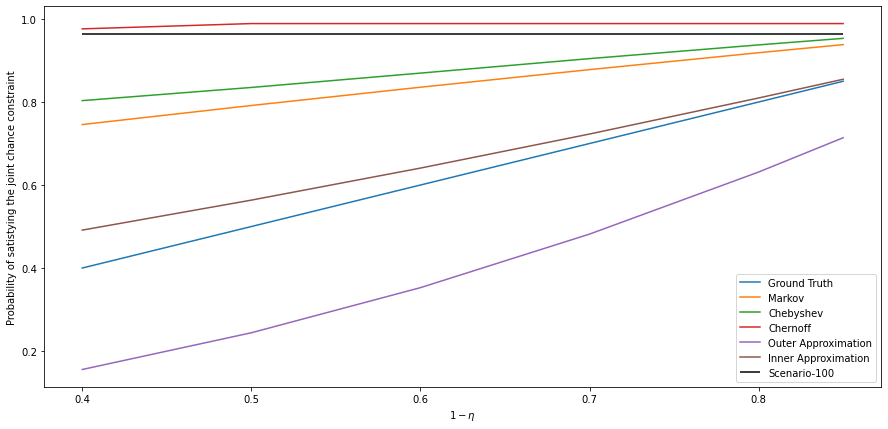

In [19]:
plt.figure(figsize=(15,7))
for label, approx in approx_dict.items():
    probas = []
    for eta in etas:
        approx_res = approx(eta)
        if label != "Ground Truth" and label != "Outer Approximation" and label != "Inner Approximation":
            probas.append(check_cc(approx_res.x[:-1]))
        else:
            probas.append(check_cc(approx_res.x))
    plt.plot(1 - np.array(etas), probas, label=label)
plt.hlines(y=check_cc(res_scenario_100.x), xmin=min(1-np.array(etas)), xmax=max(1-np.array(etas)), label='Scenario-100')
plt.legend()
plt.xlabel(r'$1-\eta$')
plt.ylabel(r'Probability of satistying the joint chance constraint')
plt.show()